# Flowers Classification
--- 

For this project i will use Oxford-flowers-102 dataset


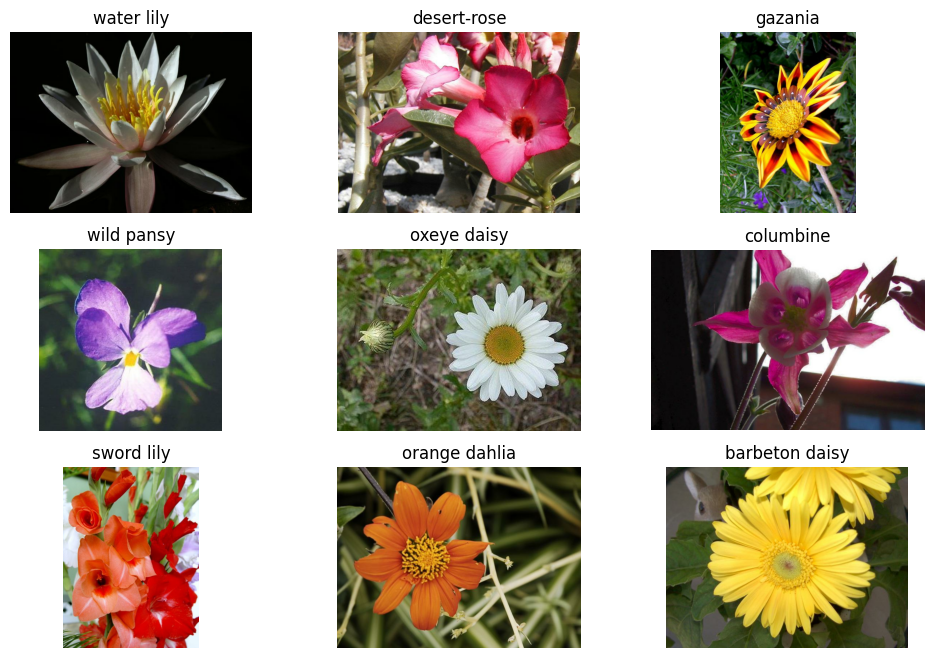

In [16]:
# load the dataset
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# create the train-test-validation datasets
train_dataset, test_dataset, validation_dataset = dataset['train'], dataset['test'], dataset['validation']

# take a look to the dataset
get_label_name = info.features['label'].int2str

plt.figure(figsize=(12,8))
for i, (image, label) in enumerate(train_dataset.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()


## 1. Preprocess
---

Due to the colors are really important in this dataset, i rescale images to 160x160x3, and also apply dataaugmentation to reduce the possible overfitting

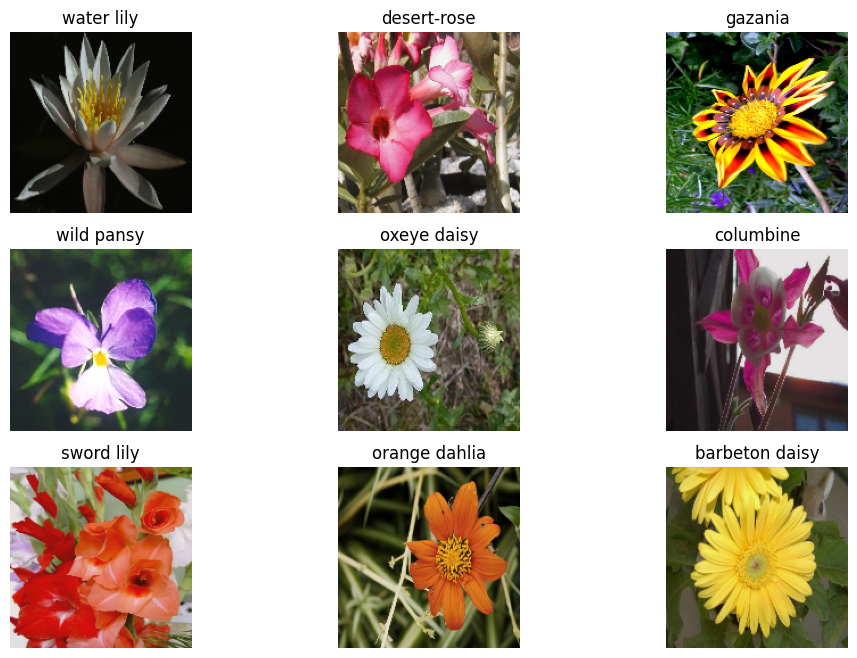

In [17]:
# due to the images had different sizes, we are going to keep them all in 120x120
size_image = [160,160]

def image_transformation_train(img, label):
  # resize the image
  img = tf.image.resize(img, size_image)
  # normalize
  img = tf.image.random_flip_left_right(img) 
  img = tf.image.random_brightness(img, max_delta=0.2)
  img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
  img = tf.cast(img, tf.float32) / 255.0
  return img, label

def image_transformation_test(img, label):
  # resize the image
  img = tf.image.resize(img, size_image)
  # normalize
  img = tf.cast(img, tf.float32) / 255.0
  return img, label
batch_size = 32
train_dataset = train_dataset.map(image_transformation_train)
test_dataset = test_dataset.map(image_transformation_test)
validation_dataset = validation_dataset.map(image_transformation_test)

plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(train_dataset.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

## 2. Create the model
---

For this project i want to test the MobileNetv2 and modify the last layers in order to adapt it to this dataset.

In [18]:
from re import L
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False)
def create_model():
  return models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(102, activation='softmax')  # Oxford Flowers 102
])

## 3. Train and Test
---

In [19]:
from sklearn.model_selection import learning_curve
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam, Adamax

#model_1 = create_model(120, num_dense=200, activ_conv='relu',
#                 activ_dense='relu', padding='same')
file_path = 'best_model_feedback.keras'
if os.path.isfile(file_path):
    print("Cargando modelo")
    model_1 = tf.keras.models.load_model(file_path)
else:
    print("Creando modelo")
    model_1 = create_model()
print(model_1.summary())

# i have tested others optimizers, but in this case, this has beem the best one
optimizer_a = Adamax(learning_rate=0.0001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=1,
    min_lr=0.00000001
)

model_1.compile(
    optimizer=optimizer_a,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_1 = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max' )

## Train and save the best model, also usign lr reduction and early stopping
num_epochs = 100
history_1 = model_1.fit(train_dataset, epochs=num_epochs, batch_size=batch_size,
                        verbose=1, validation_data=(test_dataset),
                        callbacks=[checkpoint_1, early_stopping, reduce_lr])

Creando modelo
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 102)               104550    
                                                                 
Total params: 3,674,278
Trainable param

## 4. Prediction
---

In [ ]:
# cargamos el mejor modelo posible:
file_path = 'best_model_feedback.keras'
if os.path.isfile(file_path):
    print("Cargando modelo")
    model_1 = tf.keras.models.load_model(file_path)
    # obtenemos las imagenes y labels
    val_images, val_labels = next(iter(validation_dataset))
    # predecimos las imagenes
    pred = model_1.predict(val_images)
    plt.figure(figsize=(20, 20))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(val_images[i].numpy())
        plt.title(f"Pred: {get_label_name(np.argmax(pred[i], axis=-1))} True:{get_label_name(val_labels[i].numpy())}")
        plt.axis("off")
        plt.savefig("Predicted flowers.png")
else: 
    print("Entrena el modelo para poder predecir") 